<a href="https://colab.research.google.com/github/kdidi99/ml_heidelberg/blob/main/red-cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4a

# 2 Red cards study

## 2.1 Loading and cleaning the data

In [143]:
import pandas as pd                                     # for dealing with csv import
import numpy as np                                      # arrays and other matlab like manipulation
import os                                               # for joining paths and filenames sensibly
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import scipy.stats.mstats as ssm                        # for bootstrap
from scipy.stats import gaussian_kde as kde
import random

from numba import jit
from datetime import datetime, date

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
import seaborn as sns    

Import the dataset in dyad format

In [27]:
filename= 'CrowdstormingDataJuly1st.csv'
df = pd.read_csv(filename)

In [28]:
#number of ref-player dyads
df.shape[0]

146028

In [29]:
#number of data points
df["games"].sum()

426572

In [31]:
df[df["games"]>2].head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
46,abdoul-camara,Abdoul Camara,FC Sochaux,France,20.02.1990,177.0,70.0,Left Winger,4,1,2,1,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
48,ahmed-kantari,Ahmed Kantari,Stade Brest,France,28.06.1985,185.0,78.0,NaN,6,4,0,2,0,1,0,0,36844.jpg,0.25,0.25,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
52,alexis-thebaux,Alexis Thébaux,Stade Brest,France,17.03.1985,185.0,81.0,NaN,3,0,1,2,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
58,antoine-devaux,Antoine Devaux,Stade Reims,France,21.02.1985,185.0,72.0,Defensive Midfielder,3,1,1,1,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
59,arnaud-maire,Arnaud Maire,AC Ajaccio,France,06.03.1979,181.0,74.0,NaN,3,1,1,1,0,1,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586


We have 426572 player-ref combinations in total, but only 146028 dyads. There are multiple player-referee combinations that met more than once (i.e. there were several games in which both the player and the ref were involved). This complicates the analysis, it would be better to have a datapoint for every time a player and a referee met. Therefore, the disaggregation strategy from Team Sheffield was adopted with a few modifications(https://osf.io/w7tds/)

In [37]:
@jit
def transform_data(df):
  #add new vars
  df['allreds']=df['yellowReds']+df['redCards']
  df['allredsStrict']=df['redCards']
  df['refCount']=0

  #transform victory/tie/defeat values to relative rates
  df["victories"] = df["victories"]/df["games"]
  df["ties"] = df["ties"]/df["games"]
  df["defeats"] = df["defeats"]/df["games"]

  #add a column which tracks how many games each ref is involved in
  refs=pd.unique(df['refNum'].values.ravel()) #list all unique ref IDs

  #for each ref, count their dyads
  for r in refs:
      df['refCount'][df['refNum']==r]=len(df[df['refNum']==r])    

  colnames=list(df.columns)

  j = 0
  out = [0 for _ in range(sum(df['games']))]

  for _, row in df.iterrows():
          n = row['games']
          c = row['allreds']
          d = row['allredsStrict']

          
          for _ in range(n):
                  row['allreds'] = 1 if (c-_) > 0 else 0
                  row['allredsStrict'] = 1 if (d-_) > 0 else 0
                  rowlist=list(row)  #convert from pandas Series to prevent overwriting previous values of out[j]
                  out[j] = rowlist
                  j += 1
                  if j%10000==0:    
                      print("Number "+ str(j) + " of " + str(df.shape[0]))

  pd.DataFrame(out, columns=colnames).to_csv('crowdstorm_singles.csv', index=False) 

In [38]:
%%capture 
##added to suppress output
#disaggregate dataframe
transform_data(df)

In [40]:
file_singles= 'crowdstorm_singles.csv'
dfs = pd.read_csv(file_singles)
dfs["games"] = 1 #every row now represents one game
dfs.shape[0]
dfs.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,allreds,allredsStrict,refCount
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0.0,0.0,1.0,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0,0,1
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0.0,0.0,1.0,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0.0,1.0,0.0,0,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0,0,3
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0,0,3
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0,0,3


We now have one row for every game. We adjusted the games column to only contain 1s since each row now represents one game. We also updated the victories/ties/defeats columns to relative rates. If the dyad occured only once, nothing changes; if the pair was present more often than once, both data points now have the relative rates of those events as features to ensure that the information from those columns is not lost without skewing the data.

The photo ID column is crucial; if there is no photo, we cannot use the data point since there is no skin color rating available. There are 53505 data points without photo id; we drop those.

In [45]:
dfs.isna().sum()

playerShort          0
player               0
club                 0
leagueCountry        0
birthday             0
height             357
weight            3862
position         44196
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          53505
rater1           53505
rater2           53505
refNum               0
refCountry           0
Alpha_3              1
meanIAT            201
nIAT               201
seIAT              201
meanExp            201
nExp               201
seExp              201
allreds              0
allredsStrict        0
refCount             0
dtype: int64

In [49]:
dfs = dfs.dropna()
dfs.isna().sum()

playerShort      0
player           0
club             0
leagueCountry    0
birthday         0
height           0
weight           0
position         0
games            0
victories        0
ties             0
defeats          0
goals            0
yellowCards      0
yellowReds       0
redCards         0
photoID          0
rater1           0
rater2           0
refNum           0
refCountry       0
Alpha_3          0
meanIAT          0
nIAT             0
seIAT            0
meanExp          0
nExp             0
seExp            0
allreds          0
allredsStrict    0
refCount         0
dtype: int64

Average: 121.07466297960595
Median: 11.0


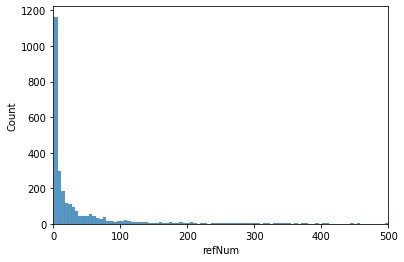

In [76]:
#look at how often a specific ref occurs in the dataframe
sns.histplot(dfs.refNum.value_counts(),kde=False, bins=1000)
plt.xlim(0,500)

#what is the median of the referee occurance?
print("Average: " + str(np.average(dfs.refNum.value_counts())))
print("Median: " + str(np.median(dfs.refNum.value_counts())))

Most of the referees occur only a few times in the whole dataset (median level 11). In a normal game there are 22 players, so each referee with less than 22 occurances seems to be erronous (for example meeting a player during a game not included in the leagues we are looking at). Therefore, we exclude all referees with less than 22 occurances in the dataset.

In [95]:
all_refs = dfs.refNum.value_counts()
good_refs = all_refs[all_refs>21]
dfs_good=dfs[dfs['refNum'].isin(good_refs.index.values)]

We have the birth date of the players, but more helpful as a feature would be their age. Therefore, we transform this features to become an age.

In [90]:
def age(born):
    born = datetime.strptime(born, "%d.%m.%Y").date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))

In [107]:
dfs_good.loc["Age"] = dfs_good['birthday'].apply(age)
dfs_good = dfs_good.dropna()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,allreds,allredsStrict,refCount,Age


In [108]:
dfs_good[dfs_good["allreds"]>1].head()
dfs_good.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,allreds,allredsStrict,refCount,Age
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3868.jpg,0.25,0.00,4.0,4.0,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0,0.0,30.0,42.0
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,47704.jpg,0.00,0.25,4.0,4.0,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0,0.0,30.0,36.0
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22356.jpg,1.00,1.00,4.0,4.0,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0,0.0,30.0,35.0
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16528.jpg,0.25,0.25,4.0,4.0,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0,0.0,30.0,37.0
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,36499.jpg,0.00,0.00,4.0,4.0,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0,0.0,30.0,34.0


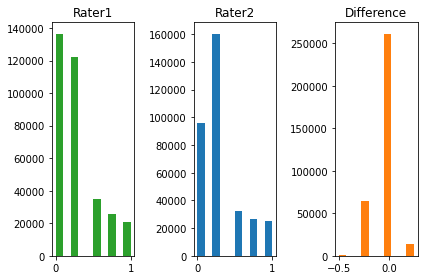

In [128]:
fig, ax = plt.subplots(1,3)
c = sns.color_palette()

ax[0].hist(dfs_good["rater1"], color = c[2])
ax[0].set_title("Rater1")

ax[1].hist(dfs_good["rater2"], color = c[0])
ax[1].set_title("Rater2")

ax[2].hist(dfs_good["rater1"]-dfs_good["rater2"], color = c[1])
ax[2].set_title("Difference")

fig.tight_layout()

There are major differences between the raters, but on most of the ratings they agree. It might therefore be a good idea to use their averaged rating as a feature.

In [134]:
dfs_good["rating"] = (dfs_good["rater1"] + dfs_good["rater2"])/2
dfs_good = dfs_good.drop(["rater1", "rater2"], axis=1)
dfs_good

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,allreds,allredsStrict,refCount,Age,rating
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3868.jpg,4.0,4.0,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0,0.0,30.0,42.0,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,47704.jpg,4.0,4.0,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0,0.0,30.0,36.0,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22356.jpg,4.0,4.0,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0,0.0,30.0,35.0,1.000
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16528.jpg,4.0,4.0,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0,0.0,30.0,37.0,0.250
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,36499.jpg,4.0,4.0,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0,0.0,30.0,34.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426566,tom-huddlestone,Tom Huddlestone,Tottenham Hotspur,England,28.12.1986,188.0,80.0,Defensive Midfielder,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,29395.jpg,3147.0,21.0,HUN,0.376127,574.0,0.000714,0.498350,606.0,0.002968,0.0,0.0,95.0,35.0,0.500
426567,tomas-rosicky,Tomáš Rosický,Arsenal FC,England,04.10.1980,178.0,67.0,Attacking Midfielder,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,444.jpg,3147.0,21.0,HUN,0.376127,574.0,0.000714,0.498350,606.0,0.002968,0.0,0.0,95.0,41.0,0.000
426568,winston-reid,Winston Reid,West Ham United,England,03.07.1988,190.0,87.0,Center Back,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,53953.jpg,3147.0,21.0,HUN,0.376127,574.0,0.000714,0.498350,606.0,0.002968,0.0,0.0,95.0,33.0,0.375
426569,xherdan-shaqiri,Xherdan Shaqiri,Bayern München,Germany,10.10.1991,169.0,72.0,Left Midfielder,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,132744.jpg,3147.0,21.0,HUN,0.376127,574.0,0.000714,0.498350,606.0,0.002968,0.0,0.0,95.0,30.0,0.250


To get a good y variable, we have to collapse the data frame so that all occurances of a single player are collapsed into one, no matter the ref.

# 2.2 Model Creation

In [148]:
#preparing data
x = np.array(dfs_good["rating"].copy())
x = x.reshape(-1,1)

y = np.array(dfs_good["allreds"].copy())
y = y.reshape(-1,1)

In [155]:
#linear regression
scores_linear = cross_val_score(LinearRegression(), x, y, cv=20)
print(scores_linear)
# scoring='neg_mean_absolute_error',

[-2.89480666e-04 -3.12644193e-06  6.63006155e-05 -5.79539559e-04
 -1.47279468e-05 -8.44722400e-04  5.88906466e-05 -3.35898330e-04
  1.42908921e-05 -8.68214991e-04 -1.76541466e-03  1.13008874e-04
 -1.59710919e-03  9.37192708e-06  8.07498560e-05  2.68627616e-05
 -5.03297682e-05  2.34312224e-05  1.01408930e-04  2.24053268e-05]


In [156]:
#regression forest
@jit
def regression_forest(x,y):
  regr = RandomForestRegressor(max_depth=2, random_state=0)
  scores = sklearn.model_selection.cross_val_score(regr, x, y.ravel(), cv=20)
  return scores

In [157]:
scores_forest = regression_forest(x,y)
print(scores_forest)

<ipython-input-156-aa611a82e3a0>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "regression_forest" failed type inference due to: Untyped global name 'RandomForestRegressor': cannot determine Numba type of <class 'abc.ABCMeta'>

File "<ipython-input-156-aa611a82e3a0>", line 4:
def regression_forest(x,y):
  regr = RandomForestRegressor(max_depth=2, random_state=0)
  ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "regression_forest" was compiled in object mode without forceobj=True.

File "<ipython-input-156-aa611a82e3a0>", line 3:
@jit
def regression_forest(x,y):
^

  state.func_ir.loc))
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/n

[-1.13290120e-04  4.85722253e-05  1.98380411e-04 -4.18146058e-04
 -5.68669036e-05 -8.24739887e-04  1.24967849e-05 -4.37413268e-04
 -1.92401347e-04 -7.33336511e-04 -1.73241203e-03  2.22572776e-04
 -1.68447014e-03  1.36067935e-04 -5.50330794e-07 -6.81755801e-05
 -1.91438621e-04  8.05689633e-06  1.46187474e-04 -2.37529706e-05]
